# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [235]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [236]:
df = pd.read_csv('amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score).
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


<Axes: xlabel='ACTION', ylabel='count'>

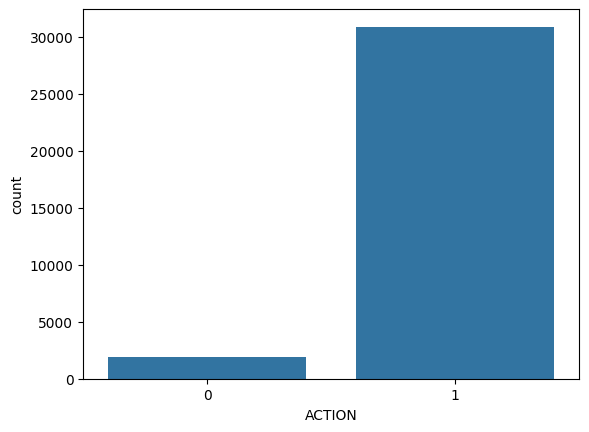

In [237]:
print(df['ACTION'].mean())
sns.countplot(x = 'ACTION', data=df)

In [238]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [239]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`.

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

<Axes: >

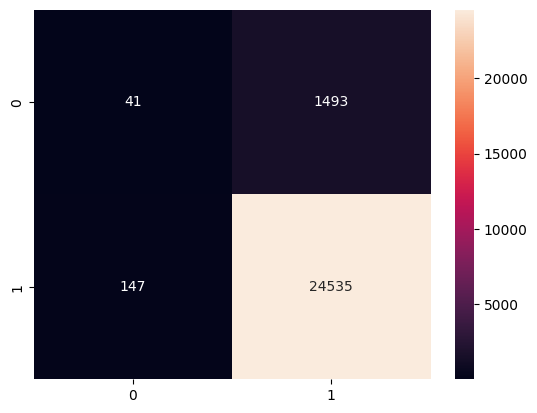

In [240]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [241]:
for p in [1, 2, 4, 6]:
    knn = KNeighborsClassifier(n_neighbors = 10, p = p)
    scores = cross_val_score(knn, X, y, cv=5, scoring='f1')
    print(f'p = {p} :mean F1 = {scores.mean()}')
    print(f'std F1 = {scores.std()}')

p = 1 :mean F1 = 0.9691350701635774
std F1 = 0.0006232325336723901
p = 2 :mean F1 = 0.9688765066583487
std F1 = 0.00041785612452251717
p = 4 :mean F1 = 0.9690268561563637
std F1 = 0.0005040464366316359
p = 6 :mean F1 = 0.9690096878343647
std F1 = 0.0004572729549381193


# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому.

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [242]:
data = pd.DataFrame(index=df.index)
for col_name in df.columns:
    if col_name == 'ACTION':
        continue
    for i in range(3):
      counts = df.loc[(df.index % 3 == i), col_name].value_counts()
      successes = df.loc[(df.index % 3 == i) & (df['ACTION'] == 1), col_name].value_counts()

      data[f'{col_name}CountsFold{i}'] = df[col_name].apply(lambda x: counts.get(x, 0))
      data[f'{col_name}SuccessesFold{i}'] = df[col_name].apply(lambda x: successes.get(x, 0))
      data[f'{col_name}SmoothFold{i}'] = (data[f'{col_name}SuccessesFold{i}'] + 1) / (data[f'{col_name}CountsFold{i}'] + 2)
data


,RESOURCECountsFold0,RESOURCESuccessesFold0,RESOURCESmoothFold0,RESOURCECountsFold1,RESOURCESuccessesFold1,RESOURCESmoothFold1,RESOURCECountsFold2,RESOURCESuccessesFold2,RESOURCESmoothFold2,MGR_IDCountsFold0,...,ROLE_FAMILYSmoothFold2,ROLE_CODECountsFold0,ROLE_CODESuccessesFold0,ROLE_CODESmoothFold0,ROLE_CODECountsFold1,ROLE_CODESuccessesFold1,ROLE_CODESmoothFold1,ROLE_CODECountsFold2,ROLE_CODESuccessesFold2,ROLE_CODESmoothFold2
0,2,2,0.750000,0,0,0.500000,1,1,0.666667,19,...,0.943225,1193,1155,0.967364,1158,1114,0.961207,1232,1198,0.971637
1,8,8,0.900000,13,13,0.933333,9,8,0.818182,2,...,0.945701,28,27,0.933333,26,26,0.964286,27,25,0.896552
2,0,0,0.500000,0,0,0.500000,2,2,0.750000,0,...,0.895692,396,350,0.881910,425,385,0.903981,435,382,0.876430
3,1,1,0.666667,0,0,0.500000,0,0,0.500000,20,...,0.943225,1552,1438,0.925997,1592,1459,0.915935,1505,1382,0.917717
4,2,2,0.750000,2,2,0.750000,4,4,0.833333,7,...,0.794872,27,24,0.862069,23,21,0.880000,25,20,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,16,15,0.888889,20,17,0.818182,15,14,0.882353,8,...,0.943225,1552,1438,0.925997,1592,1459,0.915935,1505,1382,0.917717
32765,1,1,0.666667,0,0,0.500000,1,1,0.666667,2,...,0.952381,7,7,0.888889,6,6,0.875000,11,11,0.923077
32766,55,54,0.964912,55,53,0.947368,51,48,0.924528,2,...,0.965517,3,3,0.800000,0,0,0.500000,0,0,0.500000
32767,3,3,0.800000,3,3,0.800000,1,1,0.666667,3,...,0.847619,146,131,0.891892,138,128,0.921429,110,101,0.910714


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [243]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.5)
model = KNeighborsClassifier(n_neighbors=10, p=2)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
scores.mean()

0.9389037555195626

              precision    recall  f1-score   support

           0       0.50      0.16      0.24       942
           1       0.95      0.99      0.97     15443

    accuracy                           0.94     16385
   macro avg       0.72      0.57      0.60     16385
weighted avg       0.92      0.94      0.93     16385



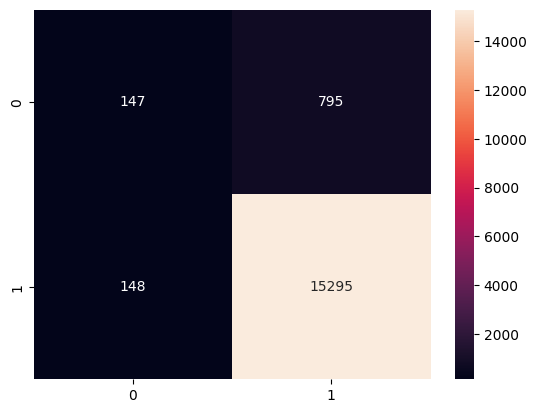

In [244]:
model.fit(X_train, y_train)
pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')
print(classification_report(y_test, pred))

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

Ответ: количество TN и TP увеличелось, значит качество выросло

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [245]:
df_combo = df.copy()
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
      df_combo[df.columns[i] + '_' + df.columns[j]] = df[df.columns[i]].astype(str) + '_' + df[df.columns[j]].astype(str)

In [246]:
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    for i in range(3):
        counts = df_combo.loc[df_combo.index % 3 == i, col_name].value_counts()
        successes = df_combo.loc[(df_combo.index % 3 == i) & (df_combo['ACTION'] == 1), col_name].value_counts()

        df_combo[f'{col_name}CountsFold{i}'] = df_combo[col_name].apply(lambda x: counts.get(x, 0))
        df_combo[f'{col_name}SuccessesFold{i}'] = df_combo[col_name].apply(lambda x: successes.get(x, 0))
        df_combo[f'{col_name}SmoothFold{i}'] = (df_combo[col_name].apply(lambda x: successes.get(x, 0)) + 1) / (df_combo[col_name].apply(lambda x: counts.get(x, 0)) + 2)
df_combo

<ipython-input-246-69cafaf166ff>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_combo[f'{col_name}CountsFold{i}'] = df_combo[col_name].apply(lambda x: counts.get(x, 0))
<ipython-input-246-69cafaf166ff>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_combo[f'{col_name}SuccessesFold{i}'] = df_combo[col_name].apply(lambda x: successes.get(x, 0))
<ipython-input-246-69cafaf166ff>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,...,ROLE_FAMILY_DESC_ROLE_CODESmoothFold2,ROLE_FAMILY_ROLE_CODECountsFold0,ROLE_FAMILY_ROLE_CODESuccessesFold0,ROLE_FAMILY_ROLE_CODESmoothFold0,ROLE_FAMILY_ROLE_CODECountsFold1,ROLE_FAMILY_ROLE_CODESuccessesFold1,ROLE_FAMILY_ROLE_CODESmoothFold1,ROLE_FAMILY_ROLE_CODECountsFold2,ROLE_FAMILY_ROLE_CODESuccessesFold2,ROLE_FAMILY_ROLE_CODESmoothFold2
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,...,0.973510,1193,1155,0.967364,1158,1114,0.961207,1232,1198,0.971637
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,...,0.857143,28,27,0.933333,26,26,0.964286,27,25,0.896552
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,...,0.750000,396,350,0.881910,425,385,0.903981,435,382,0.876430
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,...,0.946237,1552,1438,0.925997,1592,1459,0.915935,1505,1382,0.917717
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,...,0.777778,27,24,0.862069,23,21,0.880000,25,20,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,1,23497,16971,117961,118300,119993,118321,240983,290919,118322,...,0.946237,1552,1438,0.925997,1592,1459,0.915935,1505,1382,0.917717
32765,1,25139,311198,91261,118026,122392,121143,173805,249618,121145,...,0.750000,7,7,0.888889,6,6,0.875000,11,11,0.923077
32766,1,34924,28805,117961,118327,120299,124922,152038,118612,124924,...,0.500000,3,3,0.800000,0,0,0.500000,0,0,0.500000
32767,1,80574,55643,118256,118257,117945,280788,280788,292795,119082,...,0.869565,146,131,0.891892,138,128,0.921429,110,101,0.910714


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Ответ: похоже на переобучение

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!



In [247]:
model = KNeighborsClassifier(n_neighbors=10, p=2)
X_train, X_test, y_train, y_test = train_test_split(df_combo, y, test_size=0.5)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
scores.mean()

0.9415893806800124

              precision    recall  f1-score   support

           0       0.20      0.01      0.02       954
           1       0.94      1.00      0.97     15431

    accuracy                           0.94     16385
   macro avg       0.57      0.50      0.50     16385
weighted avg       0.90      0.94      0.91     16385



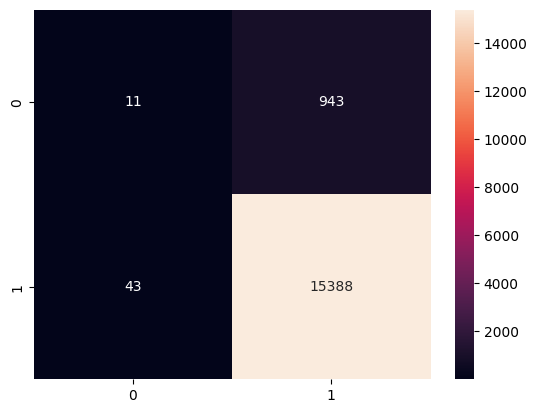

In [248]:
model.fit(X_train, y_train)
pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')
print(classification_report(y_test, pred))

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [249]:
df_target = df.copy()

In [250]:
data_target = pd.DataFrame(index=df_target.index)
for col_name in df_target.columns:
    if col_name == 'ACTION':
        continue
    data_target[col_name + 'ActionMean'] = df_target.groupby(col_name)['ACTION'].transform('mean')
    df_target[col_name] = data_target[col_name + 'ActionMean']

In [251]:
model = KNeighborsClassifier(n_neighbors=10, p=2)
X_train, X_test, y_train, y_test = train_test_split(data_target, y, test_size=0.5)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
scores.mean()

0.9683836693601723

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       903
           1       0.98      0.99      0.98     15482

    accuracy                           0.97     16385
   macro avg       0.87      0.84      0.86     16385
weighted avg       0.97      0.97      0.97     16385



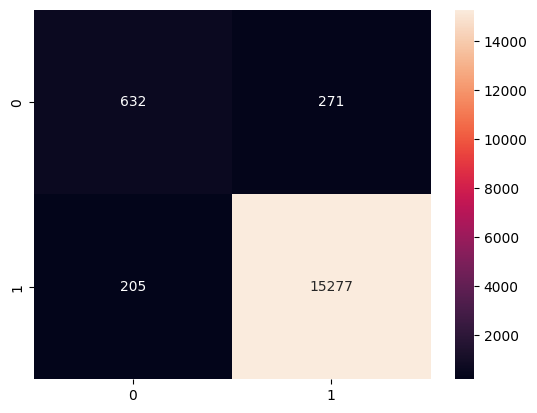

In [252]:
model.fit(X_train, y_train)
pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')
print(classification_report(y_test, pred))

Сравните результаты.

Какой недостаток есть у target encoding?

Ответ: результаты стали значительно лучше. Недостатком является то, что угадываем не все случаи

